# Continuously-observed: unknown event types

Let $\mathbb{Y} = \{ X(t_i) \}_{i}$ be observed data. The total birth rate from state $k$ is the sum of PW and HO rates 

$$
\lambda_{k}(\beta_1, \beta_2) = \beta_1 S_{k}^{(1)} + \beta_2 S_{k}^{(2)} = a_{k}(\beta_1) + b_{k}(\beta_2)
$$


## Definitions

In [1]:
def sk1(k, N):
    r""" Calculates structural count $S_{k}^{(1)}$ for CSC. """
    if k <= 0 or k >= N:
        return 0
    return k * (N - k)

def sk2(k, N):
    r""" Calculates structural count $S_{k}^{(2)}$ for CSC. """
    if k < 2 or k >= N:
        return 0
    return 0.5 * k * (k - 1) * (N - k)

def lambda_k(k, N, beta1, beta2):
    r""" Calculates birth rate from state k for CSC. """
    return beta1 * sk1(k, N) + beta2 * sk2(k, N)

In [2]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from simulate_gillespie import gillespie_sim_complete

## Setup

In [3]:
N = 100
I0 = 10
time_max = 10.0
mu_true = 1.0

# true parameters for data generation 
# Case 1: "Balanced"
beta1_s_val_true, beta2_s_val_true = (2.4, 4.4)

# convert SCALED true betas to ORIGINAL per-interaction true betas
beta1_orig_true = beta1_s_val_true / N
beta2_orig_true = beta2_s_val_true / (N**2)

## Generate data

In [4]:
nsims = 1 # NOTE: single run
# TODO: try with 10, or even 100 runs

X_sims = []
for _ in range(nsims):
    X_t = gillespie_sim_complete(N, beta1_orig_true, beta2_orig_true, mu_true, I0, time_max)
    X_sims.append(X_t)

Plot saved to ../figures/inference/data.pdf


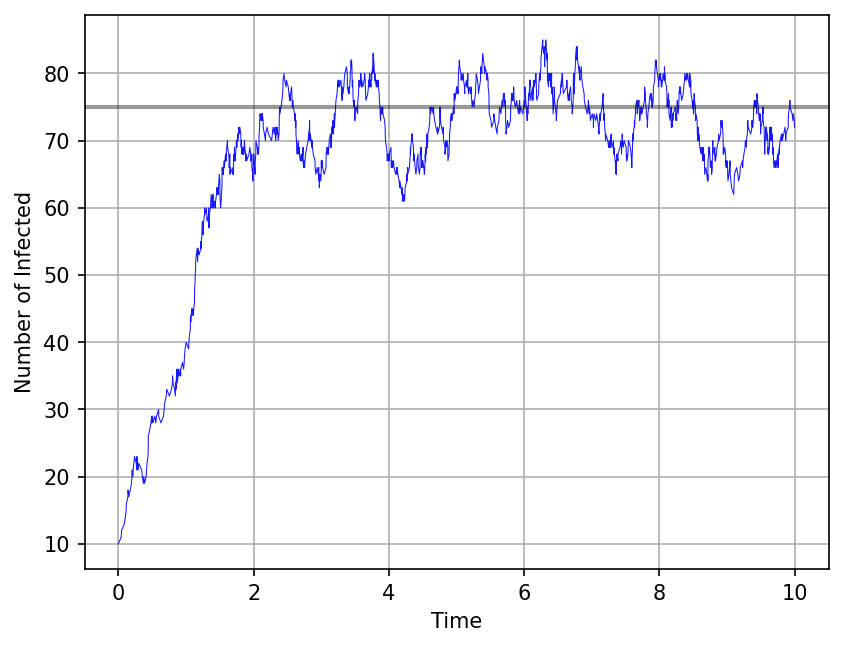

In [ ]:
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()
ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)
plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)

output_filename = "../figures/inference/no_event_data.pdf"
plt.savefig(output_filename, bbox_inches='tight')
print(f"Plot saved to {output_filename}")

plt.show()

In [6]:
# X_t = [t, waiting_time, total_infected, event_type, total_pw_count, total_ho_count]

## Sufficient (aggregated) statistics

- $B_k$: Total number of observed births from state $k$.
- $D_k$: Total number of observed deaths from state $k$.
- $T_k$: Total time spent in state $k$.

In [7]:
def get_sufficient_stats(trajectory, N):
    r"""
    Calculates the sufficient statistics: `T_k, B_k, D_k` from a single run (trajectory):
        - trajectory[0, :] are event times
        - trajectory[2, :] are states (total infected)
    """
    times = trajectory[0]
    states = trajectory[2].astype(int)

    T_k = np.zeros(N + 1)
    B_k = np.zeros(N + 1)
    D_k = np.zeros(N + 1)

    for i in range(len(times) - 1):
        current_k = states[i]
        
        time_spent = times[i + 1] - times[i]
        T_k[current_k] += time_spent

        # Determine the event at the end of the interval
        next_k = states[i+1]
        if next_k > current_k:
            # then it was a birth event from current_k state
            B_k[current_k] += 1
        elif next_k < current_k:
            # it was a death event from current_k state
            D_k[current_k] += 1
        # else: it is the final record at time_max not an event
        
    return {'T_k': T_k, 'B_k': B_k, 'D_k': D_k}

In [8]:
stats = get_sufficient_stats(X_t, N)

In [9]:
print(f"Total time spent in states:")
visited_k = np.where(stats['T_k'] > 0)[0]
for k in visited_k[:5]:
    print(f"  k={k}: T_k = {stats['T_k'][k]:.4f}")

print(f"\nTotal births from states:")
birth_k = np.where(stats['B_k'] > 0)[0]
for k in birth_k[:5]:
    print(f"  k={k}: B_k = {int(stats['B_k'][k])}")

print(f"\nTotal deaths from states:")
death_k = np.where(stats['D_k'] > 0)[0]
for k in death_k[:5]:
    print(f"  k={k}: D_k = {int(stats['D_k'][k])}")

Total time spent in states:
  k=10: T_k = 0.0411
  k=11: T_k = 0.0075
  k=12: T_k = 0.0398
  k=13: T_k = 0.0150
  k=14: T_k = 0.0113

Total births from states:
  k=10: B_k = 1
  k=11: B_k = 1
  k=12: B_k = 1
  k=13: B_k = 1
  k=14: B_k = 1

Total deaths from states:
  k=18: D_k = 1
  k=20: D_k = 2
  k=21: D_k = 2
  k=22: D_k = 3
  k=23: D_k = 2


## Likelihood 

$$
\ell(\beta_1, \beta_2) = \sum_{k = 0}^{N} \left[ B_k \ln(\lambda_k(\beta_1, \beta_2)) + D_k \ln(\mu_k(\mu)) - (\lambda_k(\beta_1, \beta_2) + \mu_k(\mu)) T_k \right]
$$

Create grid and plot the likelihood surface:

In [10]:
def calculate_log_likelihood(params, stats, N, mu):
    r"""
    Calculates the log-likelihood for continuously observed data without event types.
    """
    beta1, beta2 = params
    T_k, B_k, D_k = stats['T_k'], stats['B_k'], stats['D_k']
    
    logL = 0
    for k in range(N + 1):
        if T_k[k] > 0: # only states that were visited
            lambda_val = lambda_k(k, N, beta1, beta2)
            mu_val = mu * k
            # birth term
            if B_k[k] > 0:
                if lambda_val > 1e-12: # avoid log(0)
                    logL += B_k[k] * np.log(lambda_val)
                else: # zero rate: probability is zero
                    return -np.inf 
            
            # TODO: death term is not needed here
            if D_k[k] > 0:
                if mu_val > 1e-12:
                    logL += D_k[k] * np.log(mu_val)
                else:
                    return -np.inf
            
            # waiting time term
            logL -= (lambda_val + mu_val) * T_k[k]
            
    return logL

## Plotting

Plot saved to ../figures/inference/no_event_log_likelihood_contour.pdf


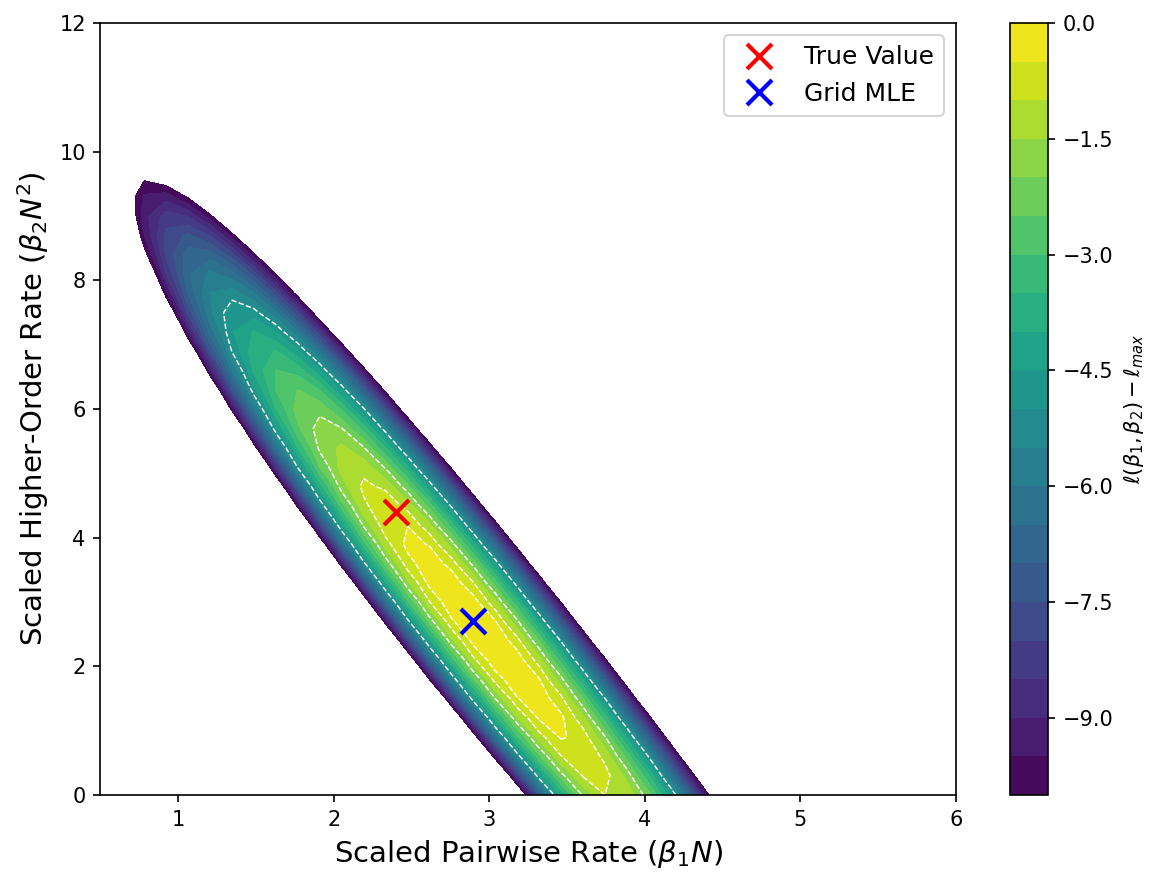

In [18]:
beta1_s_min, beta1_s_max, beta1_s_steps = 0.5, 6.0, 40
beta2_s_min, beta2_s_max, beta2_s_steps = 0.0, 12.0, 41

beta1_scaled_vec = np.linspace(beta1_s_min, beta1_s_max, beta1_s_steps)
beta2_scaled_vec = np.linspace(beta2_s_min, beta2_s_max, beta2_s_steps)

logL_surface = np.zeros((beta1_s_steps, beta2_s_steps))

for i, b1_s in enumerate(beta1_scaled_vec):
    for j, b2_s in enumerate(beta2_scaled_vec):
        # scaled params to original for likelihood calculation
        b1_orig = b1_s / N
        b2_orig = b2_s / (N**2)
        logL_surface[i, j] = calculate_log_likelihood([b1_orig, b2_orig], stats, N, mu_true)


# transpose for plotting
# meshgrid wants x, y but imshow plots i, j
logL_surface = logL_surface.T 

# grid search idea
# maximum likelihood estimate on the grid 
max_loc = np.unravel_index(np.nanargmax(logL_surface), logL_surface.shape)
mle_b2_s = beta2_scaled_vec[max_loc[0]]
mle_b1_s = beta1_scaled_vec[max_loc[1]]

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# NOTE: using a relative scale for contours
# plot contours relative to the max value
# more stable than absolute values
contour = ax.contourf(
    beta1_scaled_vec, beta2_scaled_vec, logL_surface - np.nanmax(logL_surface),
    levels=np.linspace(-10, 0, 21), # NOTE: show contours up to 10 log-units from the peak
    cmap='viridis'
)

# contour lines for better definition
ax.contour(
    beta1_scaled_vec, beta2_scaled_vec, logL_surface - np.nanmax(logL_surface),
    levels=[-5, -2, -1, -0.5],
    colors='white',
    linewidths=0.7
)

# true parameter values in red
ax.plot(beta1_s_val_true, beta2_s_val_true, 'rx', markersize=12, markeredgewidth=2, label='True Value')

# maximum likelihood estimate found on the grid
ax.plot(mle_b1_s, mle_b2_s, 'bx', markersize=12, markeredgewidth=2, label='Grid MLE')

ax.set_xlabel(r'Scaled Pairwise Rate ($\beta_1 N$)', fontsize=14)
ax.set_ylabel(r'Scaled Higher-Order Rate ($\beta_2 N^2$)', fontsize=14)
ax.legend(fontsize=12)
fig.colorbar(contour, label=r'$\ell(\beta_1, \beta_2) - \ell_{max}$')

plt.tight_layout()

output_filename = "../figures/inference/no_event_log_likelihood_contour.pdf"
plt.savefig(output_filename, bbox_inches='tight')
print(f"Plot saved to {output_filename}")

plt.show()